In [2]:
#Import libraries
import numpy as np
import torch
import gpytorch
import pandas as pd 
import matplotlib.pyplot as plt
import os
from gpytorch.constraints import Positive
from scipy.ndimage import generic_filter
torch.set_default_dtype(torch.float64)



In [4]:
## Use Nearest Neighbor Fltering to smooth data
def nn_filter(data,threshold):
    def filter_func(x):
        center = x[4]
        valid = x[~np.isnan(x)]
        if valid.size <=1:
            return np.nan
        mean_val = np.mean(np.delete(valid, np.where(valid == center)))
        deviation = abs(center-mean_val)
        return np.nan if deviation > threshold else center
    return generic_filter(data, function = filter_func, size=3, mode='constant', cval=np.nan)


##Nearest neighbor with std dev threshold:
def nn_filter(data,k):
    def filter_func(x):
        center = x[4]
        neighbors = x[~np.isnan(x)]
        if neighbors.size == 0 or np.isnan(center):
            return np.nan
        mean_val = np.mean(neighbors)
        std_val = np.std(neighbors)
        if std_val == 0 or np.isnan(std_val):
            return center
        deviation = abs(center - mean_val)
        return np.nan if deviation > k*std_val else center
    return generic_filter(data, function = filter_func, size=3, mode='constant', cval=np.nan)


In [22]:
##Use Median Filter + Adapative?

#from scipy.ndimage import median_filter
#azimuth_groups = df.groupby('azim')
#for az, subdf in azimuth_groups:
#    subdf = subdf.sort_values(['r','z']).copy()
#    r = np.sort(subdf['r'].unique())
#    z = np.sort(subdf['z'].unique())
#    R, Z = np.meshgrid(r, z)
#    Vgrid = subdf.pivot(index='r', columns='z', values='Vmag').to_numpy()
#   threshold = 10
#    median_grid = median_filter(Vgrid, size=3, mode='nearest')
#    diff = np.abs(Vgrid - median_grid)
#    Vgrid_filtered = Vgrid.copy()
#    Vgrid_filtered[diff > threshold] = np.nan

#    grid = subdf.pivot(index='r', columns='z', values='Vmag').to_numpy()
#    r_vals = np.sort(subdf['r'].unique())
#    z_vals = np.sort(subdf['z'].unique())
#    plt.figure(figsize =(20,10))
#    #plt.subplot(1,2,1)
#    plt.title(f'Raw Data Plotted (Azimuth = {az} deg)')
#    cp1 = plt.contourf(r_vals,z_vals,grid,levels=50,cmap='viridis')
#    plt.contour(r_vals,z_vals,grid,levels=10,colors='k',linewidths=0.3)
#    plt.colorbar(cp1,label='Vmag')
    #plt.subplot(1,2,2)
    #plt.title('Filtered Data Plotted (Azimuth = {az} deg)')
    #cp2 = plt.contourf(r_vals,z_vals,Vgrid_filtered,levels=50,cmap='viridis')
    #plt.contour(r_vals,z_vals,Vgrid_filtered,levels=10,colors='k',linewidths=0.3)
    #plt.colorbar(cp2,label='Vmag_filtered')
    #plt.tight_layout()
    #plt.show
    #subdf["Vmag_filtered"] = Vgrid_filtered.flatten()



In [ ]:
#Load in data

df = pd.read_csv('C:/Users/Tom/OneDrive - Georgia Institute of Technology/Desktop/CEREAL Repo/demo_outboard_CEREAL_edited.csv') 
x = torch.tensor(df[['r','z','azim']].values, dtype=torch.float32)
y = torch.tensor(df[['Vmag']].values, dtype=torch.float32).flatten()
#y = (y - y.mean())/y.std()  #Standardize output
mask = ~torch.isnan(y)
x = x[mask]
y = y[mask]
print(y)
#Define x and y coordinates, should y being velo magnitude?


tensor([13.7960, 16.5000, 20.4140,  ...,  7.7018,  5.0536,  5.5733],
       dtype=torch.float32)


tensor([255, 255, 255,  ..., 255, 255, 255], dtype=torch.uint8)

In [72]:
##Plots raw data
#azim_values = df["azim"].unique()

#for azim_sel in azim_values:
   # slice_df = df[df["azim"] == azim_sel].copy()

    # Get sorted unique coordinates
   # r_unique = np.sort(slice_df["r"].unique())
   # z_unique = np.sort(slice_df["z"].unique())

    # Create empty grid
   # Vmag_grid = np.full((len(z_unique), len(r_unique)), np.nan)

    # Fill grid with correct (r, z) matches
   # for i, r_val in enumerate(r_unique):
   #     for j, z_val in enumerate(z_unique):
   #         match = slice_df[(slice_df["r"] == r_val) & (slice_df["z"] == z_val)]
   #         if not match.empty:
   #             Vmag_grid[j, i] = match["Vmag"].values[0]

    # Plot
    #plt.figure(figsize=(8, 4))
    #contour = plt.contourf(r_unique, z_unique, Vmag_grid, levels=30, cmap="turbo")
    #plt.colorbar(contour)
    #plt.xlabel("r")
    #plt.ylabel("z")
    #plt.title(f"Azimuth Slice: {azim_sel:.0f} deg", fontweight='bold')
    #plt.axis("equal")
    #plt.tight_layout()
    #plt.show()

In [73]:
##Using Nearest Neighbor Filter w/ Fixed Threshold
#threshold = 10
#filtered_slices = []
#azimuth_groups = df.groupby('azim')
#for az, subdf in azimuth_groups:
#   subdf = subdf.sort_values(['r','z']).copy()

#    grid = subdf.pivot(index='r', columns='z', values='Vmag').to_numpy()
#    r_vals = np.sort(subdf['r'].unique())
#    z_vals = np.sort(subdf['z'].unique())
#   plt.figure(figsize =(8,6))
#    plt.subplot(1,2,1)
#    plt.title(f'Raw Data Plotted (Azimuth = {az} deg)')
#    cp1 = plt.contourf(r_vals,z_vals,grid,levels=50,cmap='viridis')
#    plt.contour(z_vals,r_vals,grid,levels=10,colors='k',linewidths=0.3)
#    plt.colorbar(cp1,label='Vmag')

#    filtered_grid = nn_filter(grid,threshold)
#    plt.subplot(1,2,2)
#    plt.title('Filtered Data Plotted (Azimuth = {az} deg)')
#    cp2 = plt.contourf(z_vals,r_vals,filtered_grid,levels=50,cmap='viridis')
#   plt.contour(z_vals,r_vals,filtered_grid,levels=10,colors='k',linewidths=0.3)
#    plt.colorbar(cp2,label='Vmag_filtered')
#    plt.tight_layout()
#    plt.show
#    subdf["Vmag_filtered"] = filtered_grid.flatten()
#    filtered_slices.append(subdf)
#
#df_filtered = pd.concat(filtered_slices, ignore_index=True)


##Using Std Dev as the filtering threshold: 
#Change threshold to k, set k to std dev of neighboring points

In [74]:
#np.unique(azim_values)

0.91949


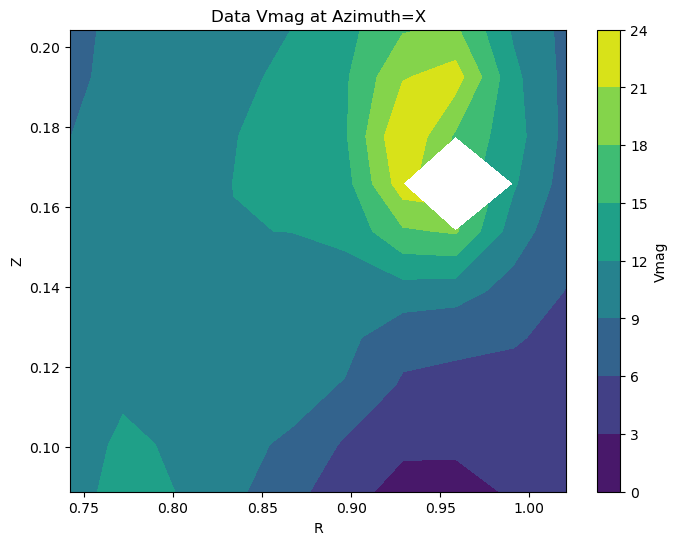

In [75]:
azim = 0.9
azim_values = df['azim'].values
azim_nearest = azim_values[np.abs(azim_values - azim).argmin()]
print(azim_nearest)
# 

slice_df = df[df['azim'] == np.unique(azim_values)[2]]
r = np.sort(slice_df['r'].unique())
z = np.sort(slice_df['z'].unique())
R, Z = np.meshgrid(r, z)
Vmag = slice_df.pivot(index='z', columns='r', values='Vmag').values
plt.figure(figsize=(8, 6))
cp = plt.contourf(r,z,Vmag,cmap='viridis')
plt.colorbar(cp,label='Vmag')
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Data Vmag at Azimuth=X')
plt.show()

In [5]:
#Define fourier kernel
train_x = torch.tensor(x)
train_y = torch.tensor(y)
class FourierKernel(gpytorch.kernels.Kernel):
    is_stationary = True # Required for kronecker
    def __init__(self, harmonics, active_dims = None):
        # initialize kernel 
        super().__init__(has_lengthscale=True, active_dims = active_dims)
        n_lambdas = 2*len(harmonics)+1

        # Define hyperparameter, lambda 
        self.register_parameter(name="raw_lambdas", parameter=torch.nn.Parameter(torch.zeros(n_lambdas))) 
        self.register_constraint("raw_lambdas", Positive()) 
        
        self.HARMONICS = harmonics
        
        # Define prior 
        self.register_prior(
                "lambdas_prior",
                gpytorch.priors.MultivariateNormalPrior(torch.zeros(n_lambdas), torch.eye(n_lambdas)), # gpytorch.priors.NormalPrior(1.5, 0.5)
                lambda m: m.lambdas,
                lambda m, v : m._set_lambdas(v),)
    
    # Set fx related to hyperparams
    @property
    def lambdas(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_lambdas_constraint.transform(self.raw_lambdas)
    @lambdas.setter
    def lambdas(self, values):
        return self._set_lambdas(values)
    def _set_lambdas(self, values):
        if not torch.is_tensor(values):
            values = torch.as_tensor(values).to(self.lambdas)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_lambdas=self.lambdas_constraint.inverse_transform(values))

    def forward(self, x1, x2, diag=False, **params):
        Fa = self.fourier_matrix_fast(x1[:,0], self.HARMONICS) # in Hz
        Fb = self.fourier_matrix_fast(x2[:,0], self.HARMONICS) # in Hz
        if use_gpu:
            k = Fa @ torch.diag(self.lambdas) @ Fb.T 
        else: 
            k = Fa @ torch.diag(self.lambdas) @ Fb.T 
        if diag==False:
            return k
        else: 
            return torch.diag(k)

    def fourier_matrix_fast(self, circumferential_locations, harmonics):
        num_harmonics = len(harmonics)
        interweaved_idx = torch.tensor(list(zip(range(num_harmonics), range(num_harmonics, 2*num_harmonics)))) 
        
        harmonics = torch.tensor(harmonics, dtype=torch.float32
                                 )
        X1 = torch.sin(torch.outer(harmonics, circumferential_locations))
        X2 = torch.cos(torch.outer(harmonics, circumferential_locations))
        XX = torch.cat((X1.T, X2.T), dim=1)
 
        XX = XX[:, interweaved_idx.flatten()]
        # print('6')
        ones_column = torch.ones((circumferential_locations.shape[0], 1), )##device=circumferential_locations.device
        # print('7')
        if use_gpu:
            XX = torch.cat((ones_column.cuda(), XX), dim=1)
            
        else: 
            XX = torch.cat((ones_column, XX), dim=1)
        return XX
    
class fourier_model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(fourier_model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = FourierKernel(harmonics)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


harmonics = torch.tensor([1, 2, 3, 4, 5])
likelihood_fourier = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.ones_like(train_y))
fourier = fourier_model(train_x, train_y, likelihood_fourier)

C:\Users\Tom\AppData\Local\Temp\ipykernel_34180\24406671.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(x)
C:\Users\Tom\AppData\Local\Temp\ipykernel_34180\24406671.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(y)


In [6]:
# THIS IS PSEUDO CODE
# this assumes training data will be N x 3 (r, z, psi)
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(active_dims=[0, 1], ard_num_dims=2, nu=5/2) * FourierKernel(harmonics = [1,2,3,4], active_dims=[2])) #4 vector harmonics, not sure what that really means just put it in as 4
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(active_dims=[0, 1, 2], ard_num_dims=3, nu=5/2))
        # to improve accuracy you will need to :
        # 1) Change around the prior distribution of hyperpameters
        # 2 ) This data is unfiltered - you should try to filter out small vector
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x, y, likelihood) #Call on GP model
model.train()
likelihood.train() # For optimizer setup 
use_gpu=False
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) #Loss function

training_iter = 50
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x) 
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")

model.eval()
likelihood.eval()

r_grid = np.linspace(df['r'].min(), df['r'].max(), 50)
z_grid = np.linspace(df['z'].min(), df['z'].max(), 50)
R, Z = np.meshgrid(r_grid, z_grid)
#Az = np.zeros_like(R)  # Fix azimuthal angle at 0 for 2D slice
Az = np.zeros_like(R) + 0.65  # Fix azimuthal angle at 0 for 2D slice
print(Az)
x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
print(np.shape(x_test))
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x_test))
    mean = pred.mean.numpy().reshape(R.shape)
    var = pred.variance.numpy().reshape(R.shape)



Iter 1/50 - Loss: 9.557
Iter 11/50 - Loss: 3.765
Iter 21/50 - Loss: 2.196
Iter 31/50 - Loss: 1.917
Iter 41/50 - Loss: 1.885
[[0.65 0.65 0.65 ... 0.65 0.65 0.65]
 [0.65 0.65 0.65 ... 0.65 0.65 0.65]
 [0.65 0.65 0.65 ... 0.65 0.65 0.65]
 ...
 [0.65 0.65 0.65 ... 0.65 0.65 0.65]
 [0.65 0.65 0.65 ... 0.65 0.65 0.65]
 [0.65 0.65 0.65 ... 0.65 0.65 0.65]]
torch.Size([2500, 3])


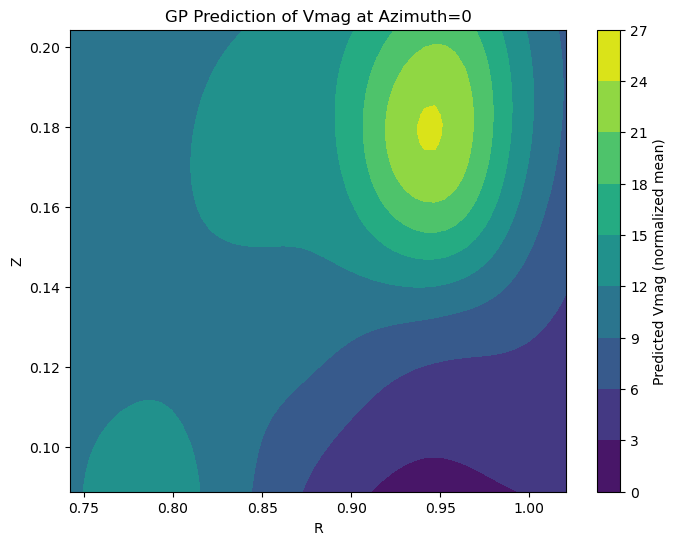

In [79]:
#Plot mean v_mag
plt.figure(figsize=(8, 6))
cp = plt.contourf(R,Z,mean,cmap='viridis')
plt.colorbar(cp,label='Predicted Vmag (normalized mean)')
plt.xlabel('R')
plt.ylabel('Z')
plt.title('GP Prediction of Vmag at Azimuth=0')
plt.show()



In [29]:
#r0, z0 = 0.88, 0.125
#thetas = np.linspace(0, 2*np.pi, 128, endpoint=False)
#X_test = torch.tensor(np.column_stack([np.full_like(thetas, r0), np.full_like(thetas, z0), thetas]), dtype=torch.float32)
#with torch.no_grad():
#    pred = likelihood(model(X_test))
#    signal = pred.mean.numpy()
#fft_vals = np.fft.fft(signal)
#freqs = np.fft.fftfreq(len(signal), d=(thetas[1]-thetas[0]))
#mask = freqs>=0
#freqs = freqs[mask]
#fft_mag = np.abs(fft_vals[mask])
#plt.figure(figsize=(8, 6))
#plt.stem(freqs,fft_mag,basefmt="")
#plt.xlabel('Frequency (Cycles/rad)')
#plt.ylabel('FFT Magnitude')
#plt.title("FFT of Vmag vs azimuth")
#plt.xlim([0, 10])
#plt.show()
    

In [28]:
#Plot v_mag variance
#plt.figure(figsize=(8, 6))
#cp = plt.contour(R,Z,var,cmap='viridis')
#plt.colorbar(cp,label='Predicted Vmag variance')
#plt.xlabel('R')
#plt.ylabel('Z')
#plt.title('GP Variance V_mag at Azimuth=0')
#plt.show()

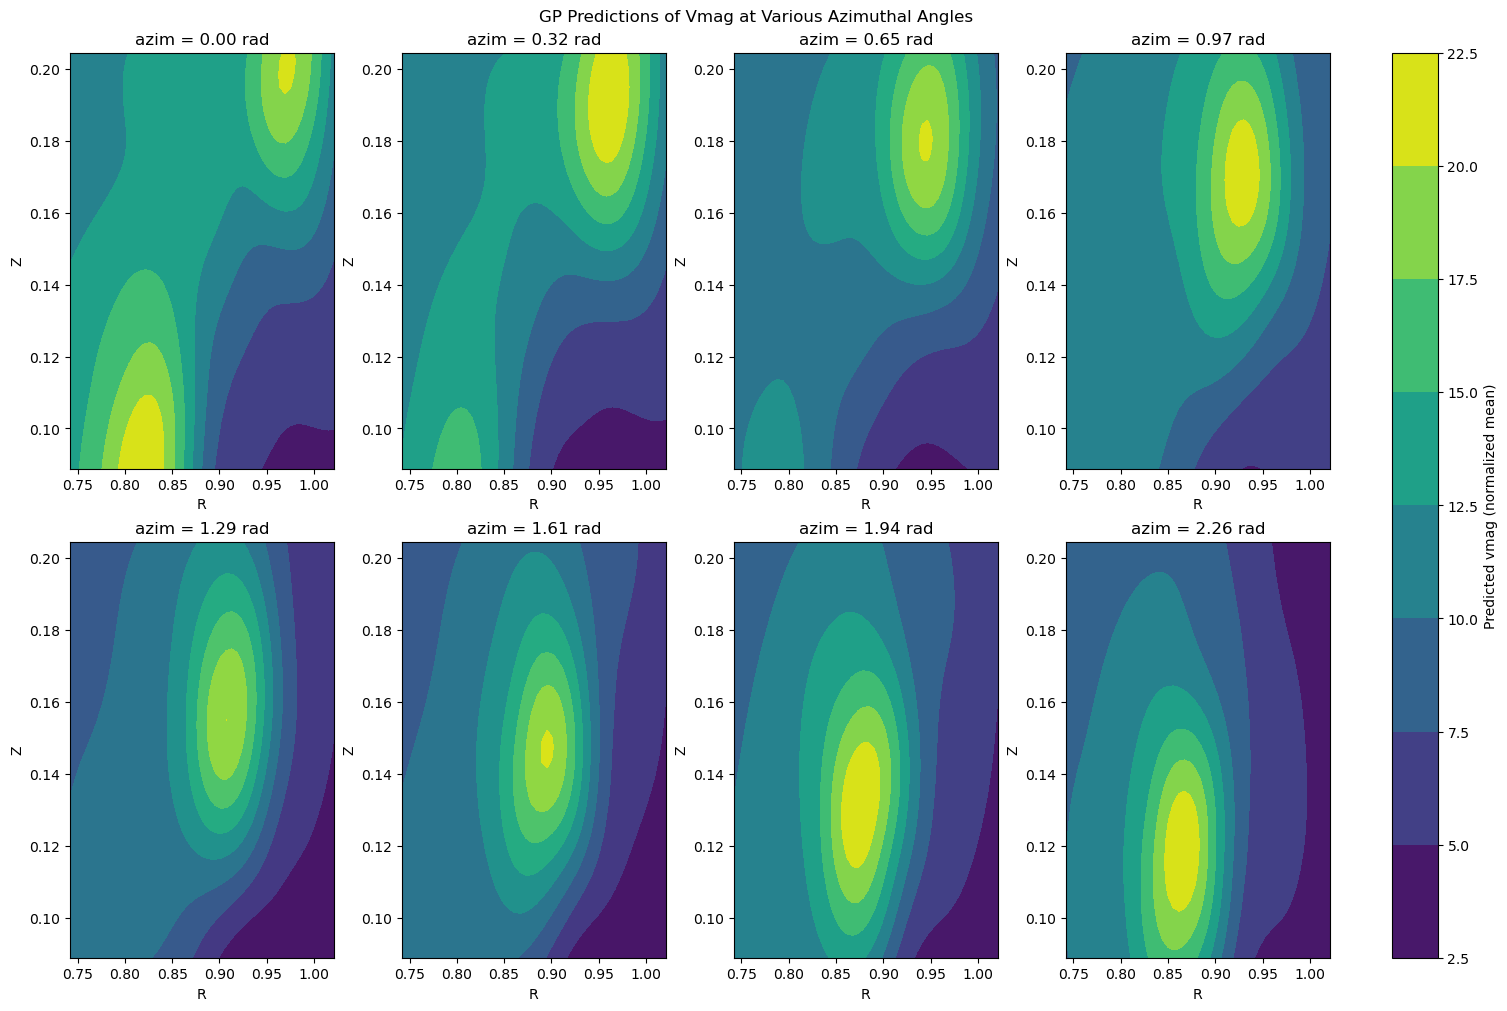

In [8]:
#Sweep through azimuthal angles and plot the vmag? or plot the r and z at different azimuthal angles?

azim_vec = np.linspace(df['azim'].min(), df['azim'].max(), 20)
fig,axes = plt.subplots(2,4,figsize=(15,10),constrained_layout = True)
for ax, az in zip(axes.ravel(), azim_vec):
    Az = np.full_like(R, az)
    x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(x_test))
        mean = pred.mean.numpy().reshape(R.shape)
    cp = ax.contourf(R,Z,mean,cmap='viridis')
    ax.set_title(f"azim = {az:.2f} rad")
    ax.set_xlabel('R')
    ax.set_ylabel('Z')
fig.colorbar(cp, ax=axes.ravel().tolist(), label='Predicted vmag (normalized mean)')
plt.suptitle('GP Predictions of Vmag at Various Azimuthal Angles')
plt.show()



#For next week, incorporate the fourier kernel definition and get the mean and std dev in data to show the flow field.

In [8]:
#azim_vec = np.linspace(df['azim'].min(), df['azim'].max(), 20)
#fig,axes = plt.subplots(2,4,figsize=(15,10),constrained_layout = True)
#for ax, az in zip(axes.ravel(), azim_vec):
#    Az = np.full_like(R, az)
#    x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
#    with torch.no_grad(), gpytorch.settings.fast_pred_var():
#        pred = likelihood(model(x_test))
#        var = pred.variance.numpy().reshape(R.shape)
#    cp = ax.contourf(R,Z,var,cmap='viridis')
#    ax.set_title(f"azim = {az:.2f} rad")
#    ax.set_xlabel('R')
#    ax.set_ylabel('Z')
#fig.colorbar(cp, ax=axes.ravel().tolist(), label='Predicted vmag variances')
#plt.suptitle('GP Predictions of Vmag variances at Various Azimuthal Angles')
#plt.show()

tensor([13.7960, 16.5000, 20.4140,  ...,  7.7018,  5.0536,  5.5733],
       dtype=torch.float32)


C:\Users\Tom\AppData\Local\Temp\ipykernel_34180\1595057358.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(x)
C:\Users\Tom\AppData\Local\Temp\ipykernel_34180\1595057358.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(y)


Iter 1/250 - Loss: 274.666
Iter 11/250 - Loss: 216.642
Iter 21/250 - Loss: 147.492
Iter 31/250 - Loss: 114.062
Iter 41/250 - Loss: 86.753
Iter 51/250 - Loss: 68.059
Iter 61/250 - Loss: 55.038
Iter 71/250 - Loss: 45.537
Iter 81/250 - Loss: 39.681
Iter 91/250 - Loss: 33.914
Iter 101/250 - Loss: 29.645
Iter 111/250 - Loss: 26.299
Iter 121/250 - Loss: 23.278
Iter 131/250 - Loss: 21.007
Iter 141/250 - Loss: 19.190
Iter 151/250 - Loss: 17.730
Iter 161/250 - Loss: 16.478
Iter 171/250 - Loss: 15.336
Iter 181/250 - Loss: 14.278
Iter 191/250 - Loss: 13.396
Iter 201/250 - Loss: 15.248
Iter 211/250 - Loss: 11.779
Iter 221/250 - Loss: 10.918
Iter 231/250 - Loss: 12.671
Iter 241/250 - Loss: 11.947
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
torch.Size([2500, 3])


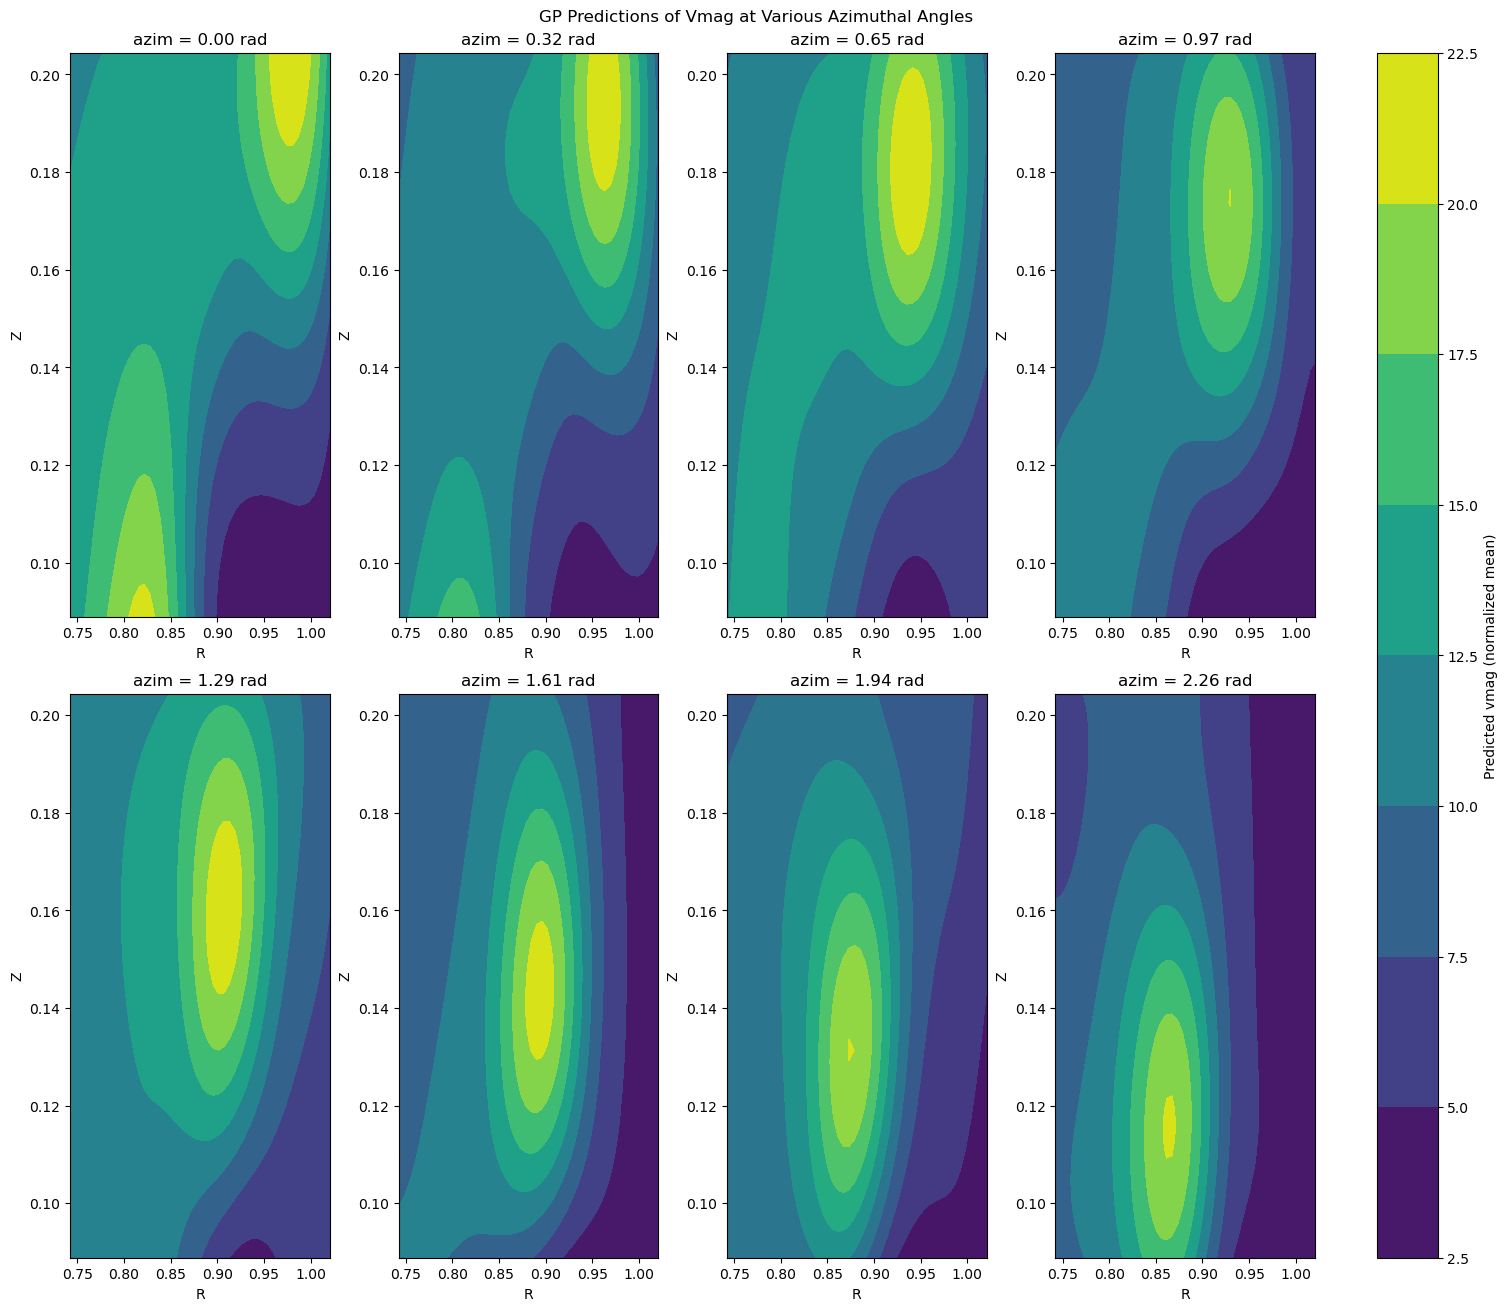

In [32]:
#Import libraries
import numpy as np
import torch
import gpytorch
import pandas as pd 
import matplotlib.pyplot as plt
import os
from gpytorch.constraints import Positive
from scipy.ndimage import generic_filter
from gpytorch.constraints import GreaterThan
torch.set_default_dtype(torch.float64)

#Load in data

df = pd.read_csv('C:/Users/Tom/OneDrive - Georgia Institute of Technology/Desktop/CEREAL Repo/demo_outboard_CEREAL_edited.csv') 
x = torch.tensor(df[['r','z','azim']].values, dtype=torch.float32)
y = torch.tensor(df[['Vmag']].values, dtype=torch.float32).flatten()
y_stand = (y - y.mean())/y.std()  #Standardize output
mask = ~torch.isnan(y)
x = x[mask]
y = y[mask]
#y_stand = y_stand[mask]
print(y)
#Define x and y coordinates, should y being velo magnitude?

#Define fourier kernel
train_x = torch.tensor(x)
train_y = torch.tensor(y)
class FourierKernel(gpytorch.kernels.Kernel):
    is_stationary = True # Required for kronecker
    def __init__(self, harmonics, active_dims = None):
        # initialize kernel 
        super().__init__(has_lengthscale=True, active_dims = active_dims)
        n_lambdas = 2*len(harmonics)+1

        # Define hyperparameter, lambda 
            ###Change 1- Initialize lambda at 0.5, rather than 0
        self.register_parameter(name="raw_lambdas", parameter=torch.nn.Parameter(torch.ones(n_lambdas)*0.5)) #Initialize to 0.5 
        #self.register_constraint("raw_lambdas", Positive()) 
        self.register_constraint("raw_lambdas", GreaterThan(1e-6))
        
        self.HARMONICS = harmonics
        
        # Define prior
            ##Change 2- Set prior to multivariate normal prior centered at 0.5 with small variance
        self.register_prior(
                "lambdas_prior",
                gpytorch.priors.MultivariateNormalPrior(torch.ones(n_lambdas)*0.5, torch.eye(n_lambdas)*0.1), # gpytorch.priors.NormalPrior(1.5, 0.5)
                lambda m: m.lambdas,
                lambda m, v : m._set_lambdas(v),)
    
    # Set fx related to hyperparams
    @property
    def lambdas(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_lambdas_constraint.transform(self.raw_lambdas)
    @lambdas.setter
    def lambdas(self, values):
        return self._set_lambdas(values)
    def _set_lambdas(self, values):
        if not torch.is_tensor(values):
            values = torch.as_tensor(values).to(self.lambdas)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_lambdas=self.lambdas_constraint.inverse_transform(values))

    def forward(self, x1, x2, diag=False, **params):
        Fa = self.fourier_matrix_fast(x1[:,0], self.HARMONICS) # in Hz
        Fb = self.fourier_matrix_fast(x2[:,0], self.HARMONICS) # in Hz
        if use_gpu:
            k = Fa @ torch.diag(self.lambdas) @ Fb.T 
        else: 
            k = Fa @ torch.diag(self.lambdas) @ Fb.T 
        if diag==False:
            return k
        else: 
            return torch.diag(k)

    def fourier_matrix_fast(self, circumferential_locations, harmonics):
        num_harmonics = len(harmonics)
        interweaved_idx = torch.tensor(list(zip(range(num_harmonics), range(num_harmonics, 2*num_harmonics)))) 
        
        harmonics = torch.tensor(harmonics, dtype=torch.float32
                                 )
        X1 = torch.sin(torch.outer(harmonics, circumferential_locations))
        X2 = torch.cos(torch.outer(harmonics, circumferential_locations))
        XX = torch.cat((X1.T, X2.T), dim=1)
 
        XX = XX[:, interweaved_idx.flatten()]
        # print('6')
        ones_column = torch.ones((circumferential_locations.shape[0], 1), )##device=circumferential_locations.device
        # print('7')
        if use_gpu:
            XX = torch.cat((ones_column.cuda(), XX), dim=1)
            
        else: 
            XX = torch.cat((ones_column, XX), dim=1)
        return XX
    
class fourier_model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(fourier_model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = FourierKernel(harmonics)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


harmonics = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
likelihood_fourier = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.ones_like(train_y))
fourier = fourier_model(train_x, train_y, likelihood_fourier)


# THIS IS PSEUDO CODE
# this assumes training data will be N x 3 (r, z, psi)
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(active_dims=[0, 1], 
                                                                                       ard_num_dims=2, 
                                                                                       nu=5/2, 
                                                                                       lengthscale_prior=gpytorch.priors.HalfNormalPrior(0.5)) * FourierKernel(harmonics = [1,2,3,4,5,6,7,8,9,10], active_dims=[2])) #4 vector harmonics, not sure what that really means just put it in as 4
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(active_dims=[0, 1, 2], ard_num_dims=3, nu=5/2))
        # to improve accuracy you will need to :
        # 1) Change around the prior distribution of hyperpameters
        # 2 ) This data is unfiltered - you should try to filter out small vector
        self.covar_module.register_prior("outputscale_prior",gpytorch.priors.NormalPrior(1.0, 0.5),"outputscale")
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.001
likelihood.register_prior("noise_prior",gpytorch.priors.GammaPrior(1.5,10),"noise")
model = ExactGPModel(x, y, likelihood) #Call on GP model
model.train()
likelihood.train() # For optimizer setup 
use_gpu=False
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) #Loss function

training_iter = 250
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x) 
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")

model.eval()
likelihood.eval()

r_grid = np.linspace(df['r'].min(), df['r'].max(), 50)
z_grid = np.linspace(df['z'].min(), df['z'].max(), 50)
R, Z = np.meshgrid(r_grid, z_grid)
#Az = np.zeros_like(R)  # Fix azimuthal angle at 0 for 2D slice
Az = np.zeros_like(R)  # Fix azimuthal angle at 0 for 2D slice
print(Az)
x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
print(np.shape(x_test))
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x_test))
    mean = pred.mean.numpy().reshape(R.shape)
    var = pred.variance.numpy().reshape(R.shape)

#Azimuth sweep to plot predictions
azim_vec = np.linspace(df['azim'].min(), df['azim'].max(), 20)
fig,axes = plt.subplots(2,4,figsize=(15,13),constrained_layout = True)
for ax, az in zip(axes.ravel(), azim_vec):
    Az = np.full_like(R, az)
    x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(x_test))
        mean = pred.mean.numpy().reshape(R.shape)
    cp = ax.contourf(R,Z,mean,cmap='viridis')
    ax.set_title(f"azim = {az:.2f} rad")
    ax.set_xlabel('R')
    ax.set_ylabel('Z')
fig.colorbar(cp, ax=axes.ravel().tolist(), label='Predicted vmag (normalized mean)')
plt.suptitle('GP Predictions of Vmag at Various Azimuthal Angles')
plt.show()

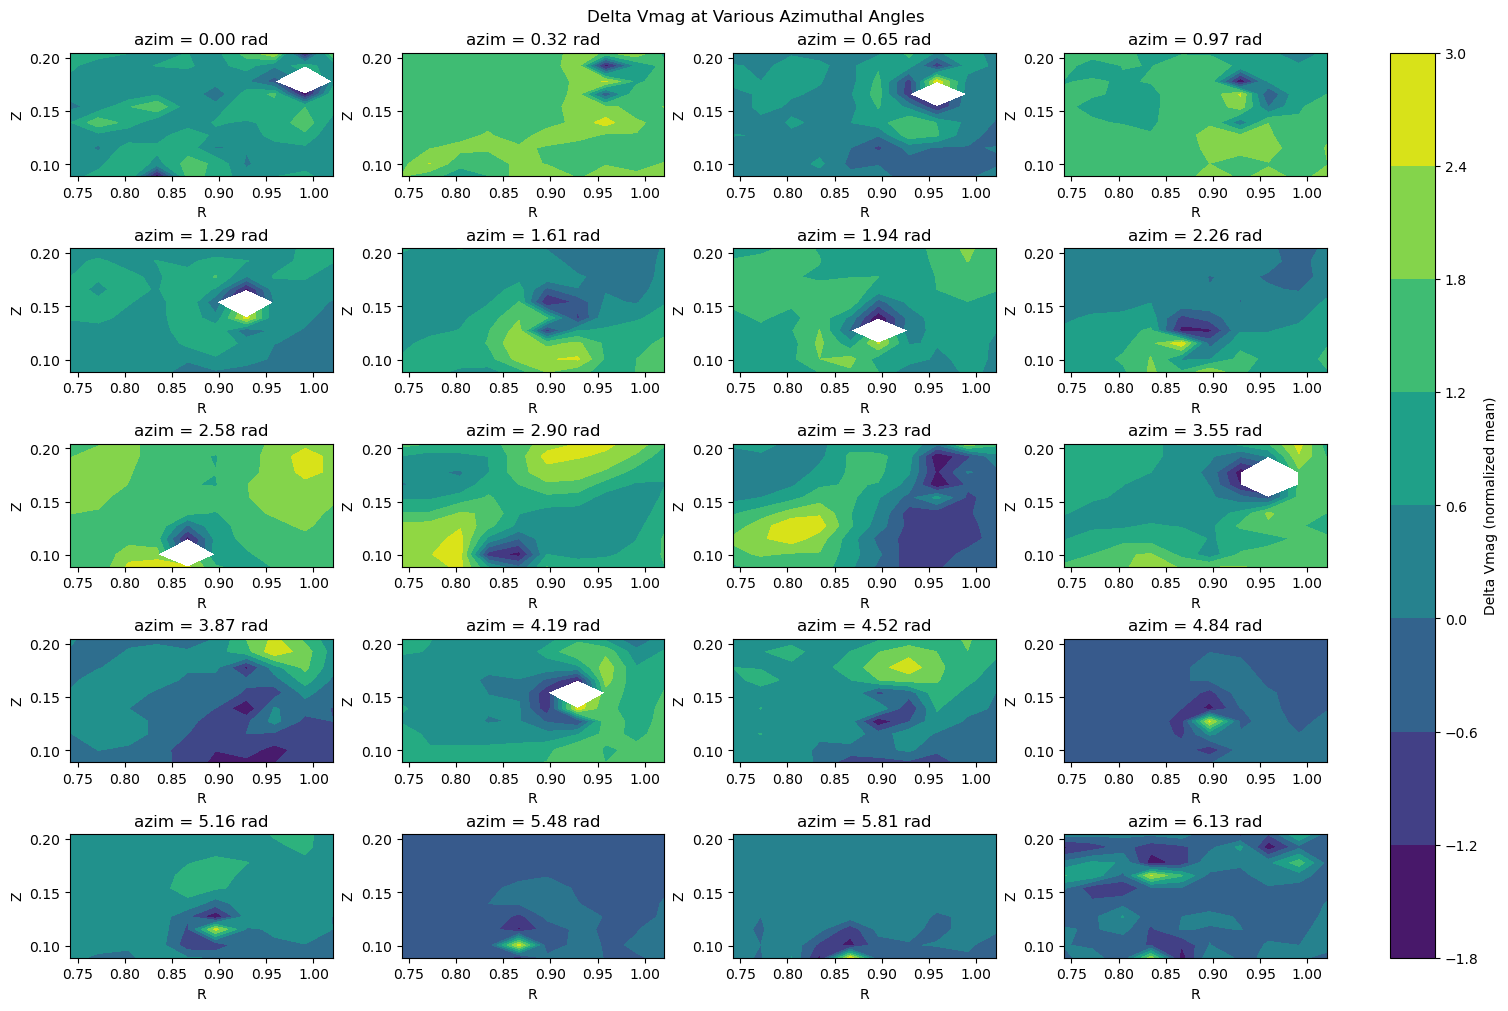

: 

In [ ]:
#Delta Vmag plots
azim_values = df['azim'].values
slice_df = df[df['azim'] == np.unique(azim_values)[2]]
r = np.sort(slice_df['r'].unique())
z = np.sort(slice_df['z'].unique())
R, Z = np.meshgrid(r, z)



azim_vec = np.linspace(df['azim'].min(), df['azim'].max(), 20)
fig,axes = plt.subplots(5,4,figsize=(15,10),constrained_layout = True)
for ax, az in zip(axes.ravel(), azim_vec):
    az_idx = np.argmin(np.abs(azim_values - az))
    az_closest = azim_values[az_idx]
    slice_df = df[np.isclose(df['azim'], az_closest)]
    Vmag = slice_df.pivot(index='z',columns='r',values='Vmag').reindex(index=z,columns=r).values
    Az = np.full_like(R, az)
    x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(x_test))
        mean = pred.mean.numpy().reshape(R.shape)
    deltaV = mean - Vmag
    cp = ax.contourf(R,Z,deltaV,cmap='viridis')
    ax.set_title(f"azim = {az:.2f} rad")
    ax.set_xlabel('R')
    ax.set_ylabel('Z')
fig.colorbar(cp, ax=axes.ravel().tolist(), label='Delta Vmag (normalized mean)')
plt.suptitle('Delta Vmag at Various Azimuthal Angles')
plt.show()

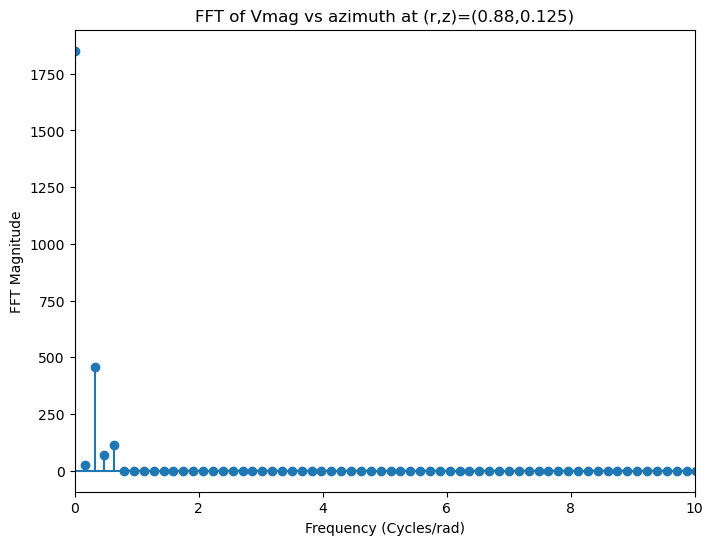

In [3]:
##Sweep through azimuth angles and plot vmag values for a fixed (r,z) location
r0, z0 = 0.88, 0.125
thetas = np.linspace(0, 2*np.pi, 128, endpoint=False)
X_test = torch.tensor(np.column_stack([np.full_like(thetas, r0), np.full_like(thetas, z0), thetas]), dtype=torch.float32)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(X_test))
    signal = pred.mean.numpy()

fft_vals = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal), d=(thetas[1]-thetas[0]))
mask = freqs>=0
freqs = freqs[mask]
fft_mag = np.abs(fft_vals[mask])
plt.figure(figsize=(8, 6))
plt.stem(freqs,fft_mag,basefmt="")
plt.xlabel('Frequency (Cycles/rad)')
plt.ylabel('FFT Magnitude')
plt.title("FFT of Vmag vs azimuth at (r,z)=(0.88,0.125)")
plt.xlim([0, 10])
plt.show()


tensor([13.7960, 16.5000, 20.4140,  ...,  7.7018,  5.0536,  5.5733],
       dtype=torch.float32)


C:\Users\Tom\AppData\Local\Temp\ipykernel_152044\4040086103.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(x)


Iter 1/250 - Loss: 14.980
Iter 11/250 - Loss: 13.605
Iter 21/250 - Loss: 12.396
Iter 31/250 - Loss: 11.336
Iter 41/250 - Loss: 10.403
Iter 51/250 - Loss: 9.574
Iter 61/250 - Loss: 8.830
Iter 71/250 - Loss: 8.152
Iter 81/250 - Loss: 7.529
Iter 91/250 - Loss: 6.951
Iter 101/250 - Loss: 6.417
Iter 111/250 - Loss: 5.926
Iter 121/250 - Loss: 5.482
Iter 131/250 - Loss: 5.083
Iter 141/250 - Loss: 4.724
Iter 151/250 - Loss: 4.399
Iter 161/250 - Loss: 4.105
Iter 171/250 - Loss: 3.837
Iter 181/250 - Loss: 3.594
Iter 191/250 - Loss: 3.374
Iter 201/250 - Loss: 3.176
Iter 211/250 - Loss: 3.000
Iter 221/250 - Loss: 2.845
Iter 231/250 - Loss: 2.710
Iter 241/250 - Loss: 2.593
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
torch.Size([2500, 3])


c:\Users\Tom\anaconda3\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(


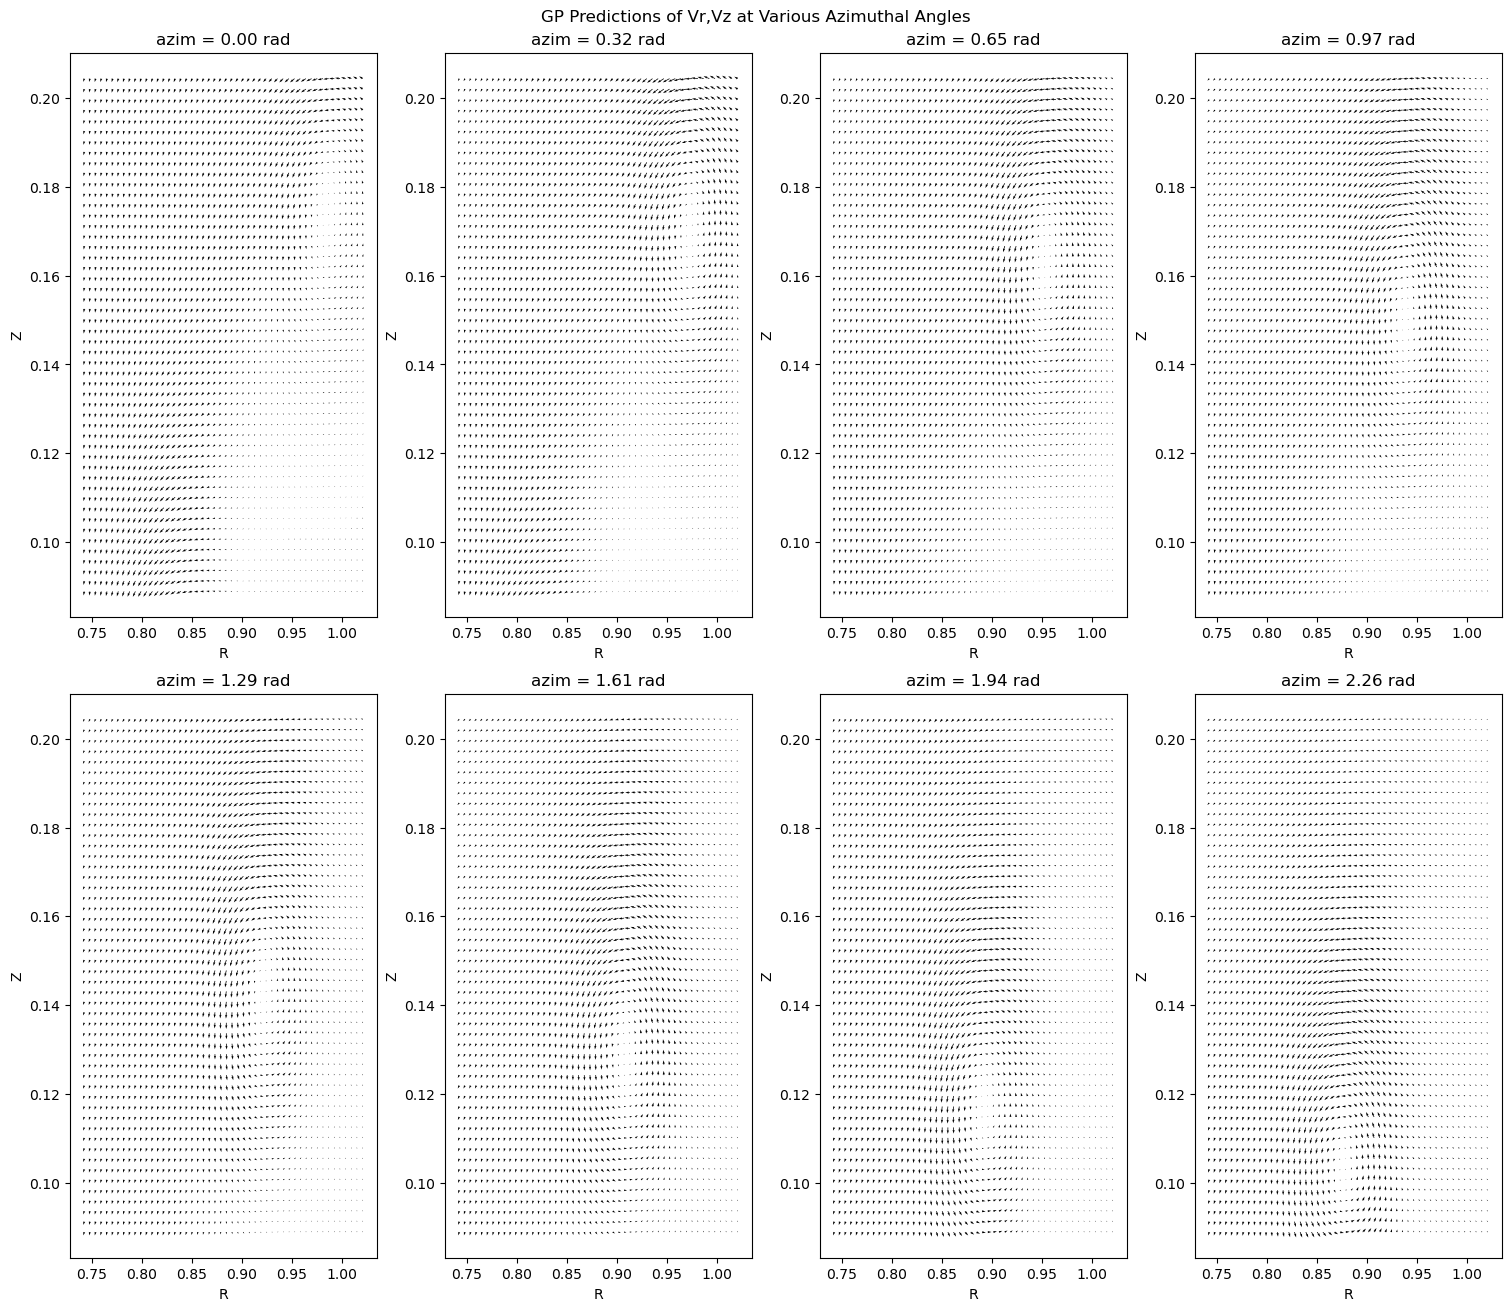

In [ ]:
##Multitask model


#Import libraries
import numpy as np
import torch
import gpytorch
import pandas as pd 
import matplotlib.pyplot as plt
import os
from gpytorch.constraints import Positive
from scipy.ndimage import generic_filter
from gpytorch.constraints import GreaterThan
torch.set_default_dtype(torch.float64)

#Load in data

df = pd.read_csv('C:/Users/Tom/OneDrive - Georgia Institute of Technology/Desktop/CEREAL Repo/demo_outboard_CEREAL_edited.csv') 
x = torch.tensor(df[['r','z','azim']].values, dtype=torch.float32)
y = torch.tensor(df[['Vmag']].values, dtype=torch.float32).flatten()
Vr = torch.tensor(df[['Vr']].values, dtype=torch.float32).flatten()
Vz = torch.tensor(df[['Vz']].values, dtype=torch.float32).flatten()
y_stand = (y - y.mean())/y.std()  #Standardize output
mask = ~torch.isnan(y)
x = x[mask]
y = y[mask]
Vr = Vr[mask]
Vz = Vz[mask]
#y_stand = y_stand[mask]
print(y)
#Define x and y coordinates, should y being velo magnitude?

#Define fourier kernel
train_x = torch.tensor(x)
train_y = torch.stack([Vr,Vz],dim=-1)
class FourierKernel(gpytorch.kernels.Kernel):
    is_stationary = True # Required for kronecker
    def __init__(self, harmonics, active_dims = None):
        # initialize kernel 
        super().__init__(has_lengthscale=True, active_dims = active_dims)
        n_lambdas = 2*len(harmonics)+1

        # Define hyperparameter, lambda 
            ###Change 1- Initialize lambda at 0.5, rather than 0
        self.register_parameter(name="raw_lambdas", parameter=torch.nn.Parameter(torch.ones(n_lambdas)*0.5)) #Initialize to 0.5 
        #self.register_constraint("raw_lambdas", Positive()) 
        self.register_constraint("raw_lambdas", GreaterThan(1e-6))
        
        self.HARMONICS = harmonics
        
        # Define prior
            ##Change 2- Set prior to multivariate normal prior centered at 0.5 with small variance
        self.register_prior(
                "lambdas_prior",
                gpytorch.priors.MultivariateNormalPrior(torch.ones(n_lambdas)*0.5, torch.eye(n_lambdas)*0.1), # gpytorch.priors.NormalPrior(1.5, 0.5)
                lambda m: m.lambdas,
                lambda m, v : m._set_lambdas(v),)
    
    # Set fx related to hyperparams
    @property
    def lambdas(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_lambdas_constraint.transform(self.raw_lambdas)
    @lambdas.setter
    def lambdas(self, values):
        return self._set_lambdas(values)
    def _set_lambdas(self, values):
        if not torch.is_tensor(values):
            values = torch.as_tensor(values).to(self.lambdas)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_lambdas=self.lambdas_constraint.inverse_transform(values))

    def forward(self, x1, x2, diag=False, **params):
        Fa = self.fourier_matrix_fast(x1[:,0], self.HARMONICS) # in Hz
        Fb = self.fourier_matrix_fast(x2[:,0], self.HARMONICS) # in Hz
        if use_gpu:
            k = Fa @ torch.diag(self.lambdas) @ Fb.T 
        else: 
            k = Fa @ torch.diag(self.lambdas) @ Fb.T 
        if diag==False:
            return k
        else: 
            return torch.diag(k)

    def fourier_matrix_fast(self, circumferential_locations, harmonics):
        num_harmonics = len(harmonics)
        interweaved_idx = torch.tensor(list(zip(range(num_harmonics), range(num_harmonics, 2*num_harmonics)))) 
        
        harmonics = torch.tensor(harmonics, dtype=torch.float32
                                 )
        X1 = torch.sin(torch.outer(harmonics, circumferential_locations))
        X2 = torch.cos(torch.outer(harmonics, circumferential_locations))
        XX = torch.cat((X1.T, X2.T), dim=1)
 
        XX = XX[:, interweaved_idx.flatten()]
        # print('6')
        ones_column = torch.ones((circumferential_locations.shape[0], 1), )##device=circumferential_locations.device
        # print('7')
        if use_gpu:
            XX = torch.cat((ones_column.cuda(), XX), dim=1)
            
        else: 
            XX = torch.cat((ones_column, XX), dim=1)
        return XX
    

# THIS IS PSEUDO CODE
# this assumes training data will be N x 3 (r, z, psi)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self,train_x,train_y,likelihood):
        super(MultitaskGPModel,self).__init__(train_x,train_y,likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(),num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(gpytorch.kernels.MaternKernel(active_dims=[0,1],
                                                                                          ard_num_dims=2,
                                                                                          nu=5/2,
                                                                                          lengthscale_prior=gpytorch.priors.HalfNormalPrior(0.5))*FourierKernel(harmonics=[1,2,3,4,5,6,7,8,9,10],active_dims=[2]),
                                                                                          num_tasks=2,rank=1
                                                            )
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x,covar_x)



likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
likelihood.noise = 0.001
likelihood.register_prior("noise_prior",gpytorch.priors.GammaPrior(1.5,10),"noise")
model = MultitaskGPModel(train_x, train_y, likelihood) #Call on GP model
model.train()
likelihood.train() # For optimizer setup 
use_gpu=False
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) #Loss function

training_iter = 250
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x) 
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")

model.eval()
likelihood.eval()


r_grid = np.linspace(df['r'].min(), df['r'].max(), 50)
z_grid = np.linspace(df['z'].min(), df['z'].max(), 50)
R, Z = np.meshgrid(r_grid, z_grid)
#Az = np.zeros_like(R)  # Fix azimuthal angle at 0 for 2D slice
Az = np.zeros_like(R)  # Fix azimuthal angle at 0 for 2D slice
print(Az)
x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
print(np.shape(x_test))
#with torch.no_grad(), gpytorch.settings.fast_pred_var():
#    pred = likelihood(model(x_test))
#    Vr_pred = pred.mean[:,0].numpy().reshape(R.shape)
#    Vz_pred = pred.mean[:,1].numpy().reshape(R.shape)
#    Vr_var = pred.variance[:,0].numpy().reshape(R.shape)
#    Vz_var = pred.variance[:,1].numpy().reshape(R.shape)

#Azimuth sweep to plot predictions
#azim_vec = np.linspace(df['azim'].min(), df['azim'].max(), 20)
#fig,axes = plt.subplots(2,4,figsize=(15,13),constrained_layout = True)
#for ax, az in zip(axes.ravel(), azim_vec):
#    Az = np.full_like(R, az)
#    x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
#    with torch.no_grad(), gpytorch.settings.fast_pred_var():
#        pred = likelihood(model(x_test))
#        Vr_pred = pred.mean[:,0].numpy().reshape(R.shape)
#        Vz_pred = pred.mean[:,1].numpy().reshape(R.shape)
#        Vr_var = pred.variance[:,0].numpy().reshape(R.shape)
#        Vz_var = pred.variance[:,1].numpy().reshape(R.shape)
#    q = ax.quiver(R, Z, Vr_pred, Vz_pred,cmap='viridis')
#    ax.set_title(f"azim = {az:.2f} rad")
#    ax.set_xlabel('R')
#    ax.set_ylabel('Z')
#fig.colorbar(cp, ax=axes.ravel().tolist(), label='Predicted vmag (normalized mean)')
#plt.suptitle('GP Predictions of Vr,Vz at Various Azimuthal Angles')
#plt.show()

In [33]:
r_grid = np.linspace(df['r'].min(), df['r'].max(), 50)
z_grid = np.linspace(df['z'].min(), df['z'].max(), 50)
R, Z = np.meshgrid(r_grid, z_grid)
#Az = np.zeros_like(R)  # Fix azimuthal angle at 0 for 2D slice
azim_vec = np.linspace(df['azim'].min(), df['azim'].max(), 20)

az = azim_vec[20]

print(len(azim_vec))
print(az)
Az = np.full_like(R, az)  # Fix azimuthal angle for 2D slice
x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
print(np.shape(x_test))
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(x_test))
    Vr_pred = pred.mean[:,0].numpy().reshape(R.shape)
    Vz_pred = pred.mean[:,1].numpy().reshape(R.shape)
    Vr_var = pred.variance[:,0].numpy().reshape(R.shape)
    Vz_var = pred.variance[:,1].numpy().reshape(R.shape)
Vmag = np.sqrt(Vr_pred**2 + Vz_pred**2)
plt.figure(figsize=(10, 8))
q = plt.quiver(R, Z, Vr_pred, Vz_pred, Vmag, cmap='viridis')
plt.xlabel('R')
plt.ylabel('Z')
plt.title(f'GP Predictions of Velocity Field at Azimuth={az:.2f} rad')
plt.colorbar(q, label='Predicted Vmag')
plt.show()


IndexError: index 20 is out of bounds for axis 0 with size 20

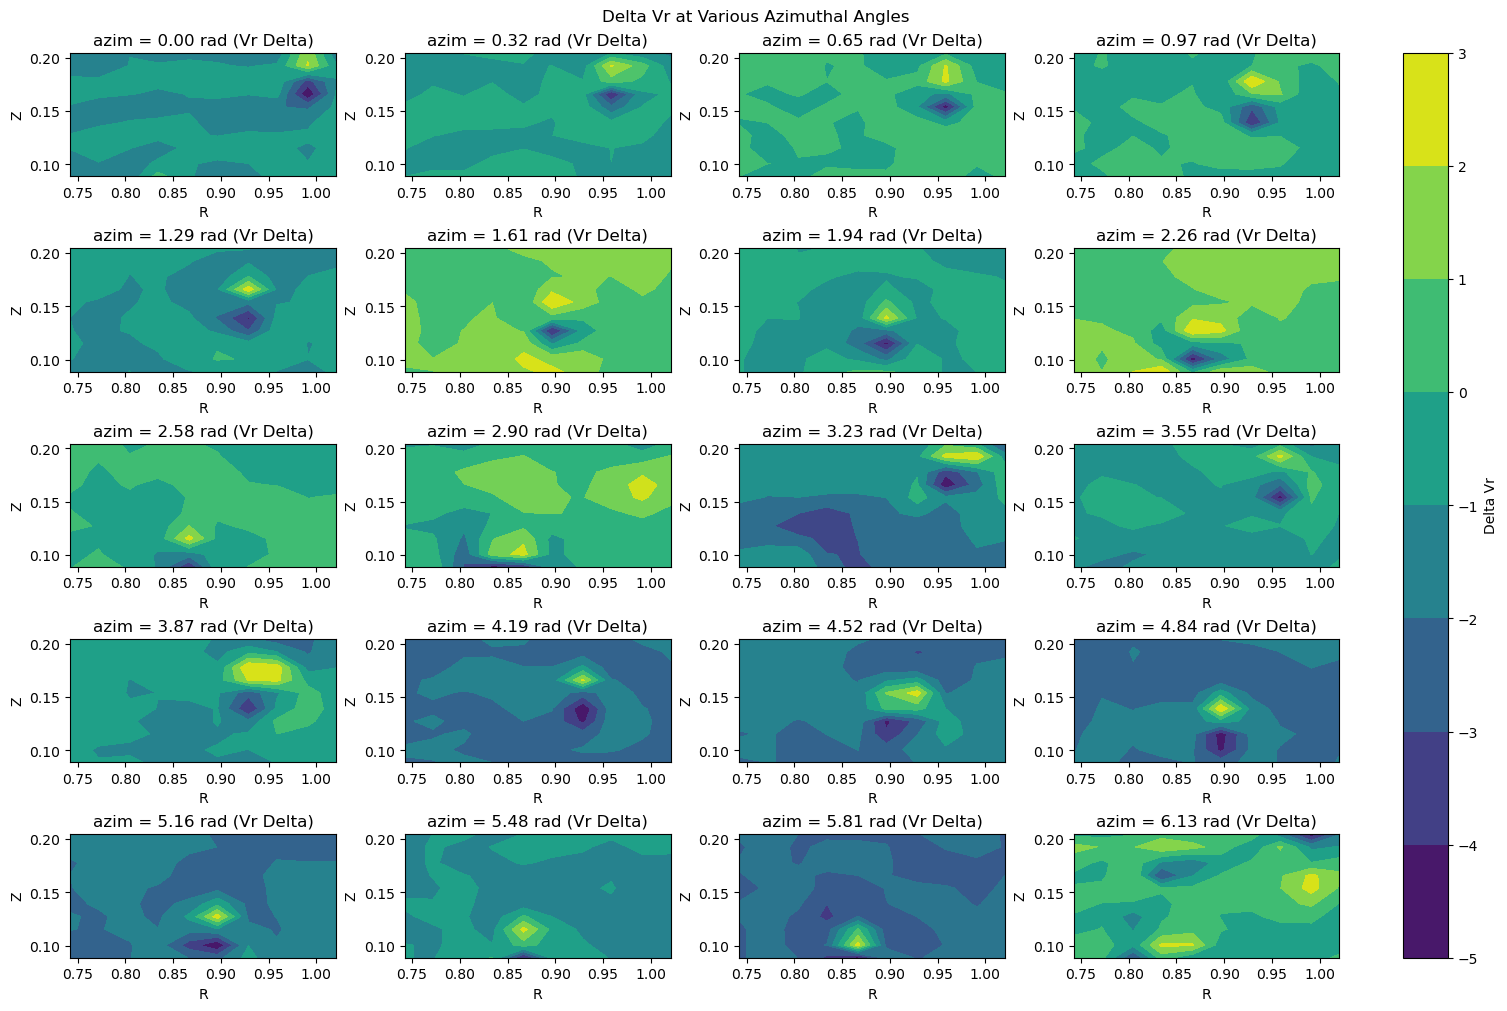

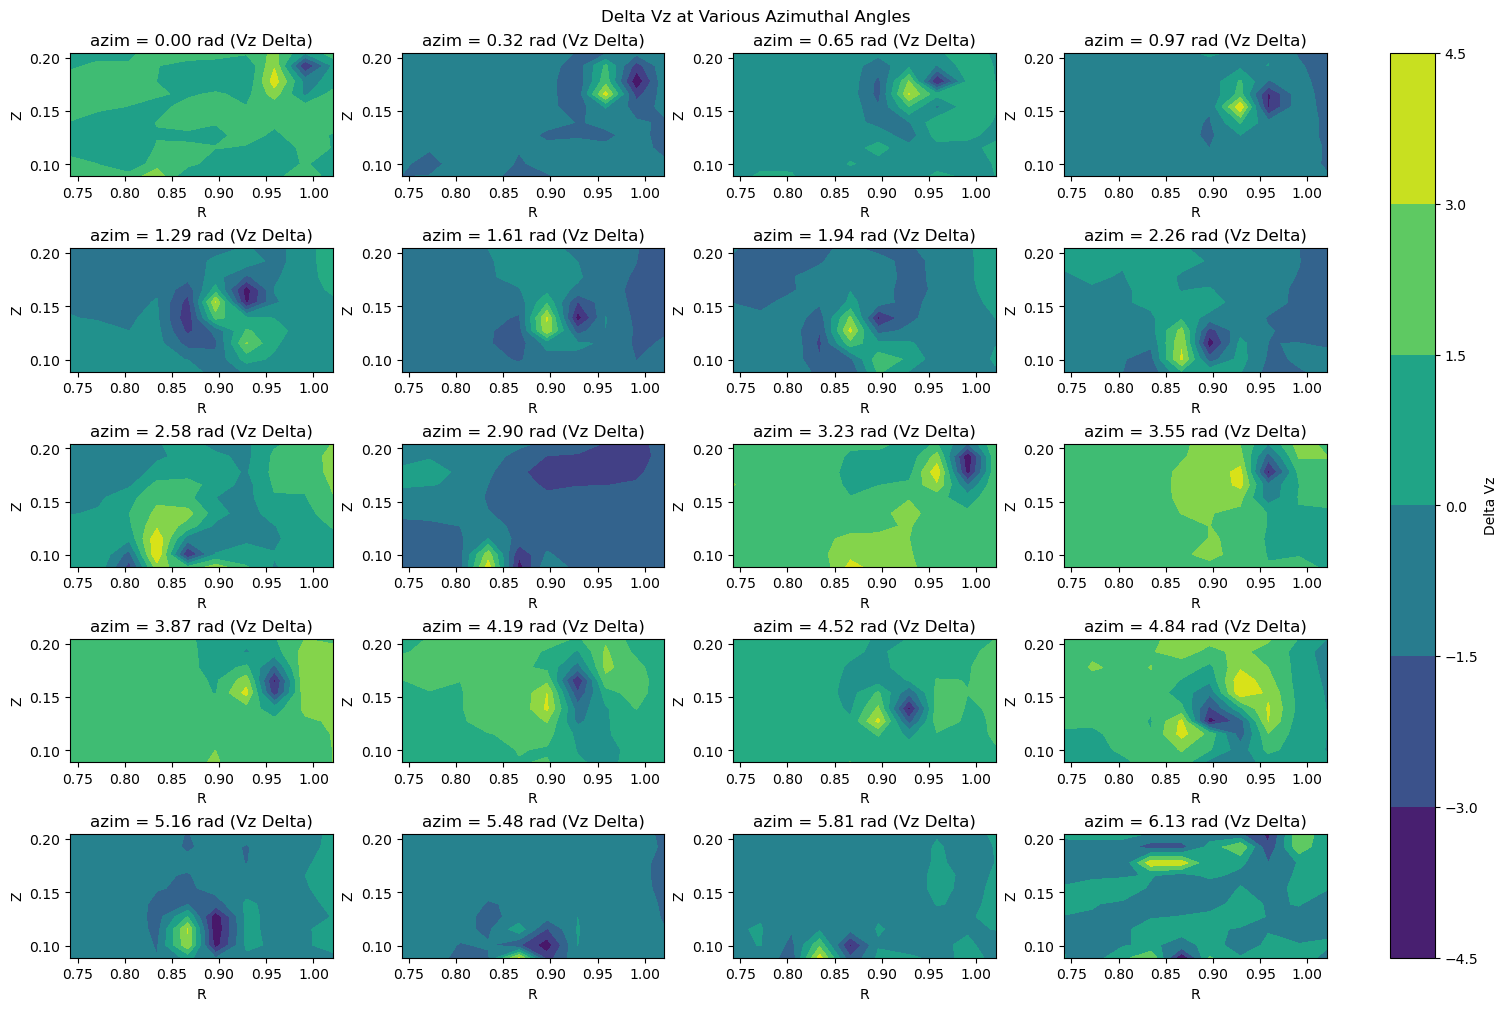

In [36]:
#Delta Vmag plots
azim_values = df['azim'].values
slice_df = df[df['azim'] == np.unique(azim_values)[2]]
r = np.sort(slice_df['r'].unique())
z = np.sort(slice_df['z'].unique())
R, Z = np.meshgrid(r, z)



azim_vec = np.linspace(df['azim'].min(), df['azim'].max(), 20)
fig,axes = plt.subplots(5,4,figsize=(15,10),constrained_layout = True)
for ax, az in zip(axes.ravel(), azim_vec):
    az_idx = np.argmin(np.abs(azim_values - az))
    az_closest = azim_values[az_idx]
    slice_df = df[np.isclose(df['azim'], az_closest)]
    Vr = slice_df.pivot(index='z',columns='r',values='Vr').reindex(index=z,columns=r).values
    Vz = slice_df.pivot(index='z',columns='r',values='Vz').reindex(index=z,columns=r).values
    Az = np.full_like(R, az)
    x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(x_test))
        Vr_pred = pred.mean[:,0].numpy().reshape(R.shape)
        Vz_pred = pred.mean[:,1].numpy().reshape(R.shape)
    deltaVr = Vr_pred - Vr
    deltaVz = Vz_pred - Vz
    cp = ax.contourf(R,Z,deltaVr,cmap='viridis')
    ax.set_title(f"azim = {az:.2f} rad (Vr Delta)")
    ax.set_xlabel('R')
    ax.set_ylabel('Z')
fig.colorbar(cp, ax=axes.ravel().tolist(), label='Delta Vr')
plt.suptitle('Delta Vr at Various Azimuthal Angles')
plt.show()

fig,axes = plt.subplots(5,4,figsize=(15,10),constrained_layout = True)
for ax, az in zip(axes.ravel(), azim_vec):
    az_idx = np.argmin(np.abs(azim_values - az))
    az_closest = azim_values[az_idx]
    slice_df = df[np.isclose(df['azim'], az_closest)]
    Vr = slice_df.pivot(index='z',columns='r',values='Vr').reindex(index=z,columns=r).values
    Vz = slice_df.pivot(index='z',columns='r',values='Vz').reindex(index=z,columns=r).values
    Az = np.full_like(R, az)
    x_test = torch.tensor(np.vstack([R.ravel(), Z.ravel(), Az.ravel()]), dtype=torch.float32).T
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(x_test))
        Vr_pred = pred.mean[:,0].numpy().reshape(R.shape)
        Vz_pred = pred.mean[:,1].numpy().reshape(R.shape)
    deltaVr = Vr_pred - Vr
    deltaVz = Vz_pred - Vz
    cp = ax.contourf(R,Z,deltaVz,cmap='viridis')
    ax.set_title(f"azim = {az:.2f} rad (Vz Delta)")
    ax.set_xlabel('R')
    ax.set_ylabel('Z')
fig.colorbar(cp, ax=axes.ravel().tolist(), label='Delta Vz')
plt.suptitle('Delta Vz at Various Azimuthal Angles')
plt.show()



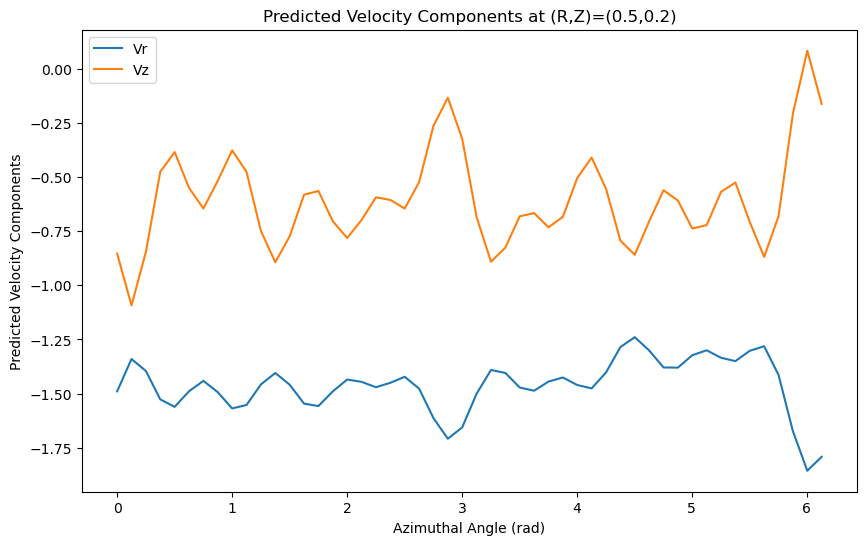

In [38]:
R_fixed = 0.5
Z_fixed = 0.2
azim_vec = np.linspace(df['azim'].min(), df['azim'].max(), 50)
Vr_preds = []
Vz_preds = []
for az in azim_vec:
    x_test = torch.tensor([[R_fixed, Z_fixed, az]], dtype=torch.float32)
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(x_test))
        Vr_preds.append(pred.mean[:,0].item())
        Vz_preds.append(pred.mean[:,1].item())
Vr_preds = np.array(Vr_preds)
Vz_preds = np.array(Vz_preds)
plt.figure(figsize=(10, 6))
plt.plot(azim_vec,Vr_preds,label='Vr')
plt.plot(azim_vec,Vz_preds,label='Vz')
plt.xlabel('Azimuthal Angle (rad)')
plt.ylabel('Predicted Velocity Components')
plt.title(f'Predicted Velocity Components at (R,Z)=({R_fixed},{Z_fixed})')
plt.legend()
plt.show()